<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Init-data" data-toc-modified-id="Init-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Init data</a></span><ul class="toc-item"><li><span><a href="#Estaciones" data-toc-modified-id="Estaciones-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Estaciones</a></span></li><li><span><a href="#Data-Mediciones" data-toc-modified-id="Data-Mediciones-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Data Mediciones</a></span></li></ul></li><li><span><a href="#Niveles-promedio-de-ozono-por-estación" data-toc-modified-id="Niveles-promedio-de-ozono-por-estación-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Niveles promedio de ozono por estación</a></span><ul class="toc-item"><li><span><a href="#Folium" data-toc-modified-id="Folium-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Folium</a></span></li></ul></li><li><span><a href="#Evolución-del-ozono-por-hora" data-toc-modified-id="Evolución-del-ozono-por-hora-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evolución del ozono por hora</a></span></li></ul></div>

In [1]:
import pandas as pd
import geopandas as gpd
from joblib import Parallel, delayed
import numpy as np
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl

import folium
from shapely.geometry import Point
import branca.colormap as cm

import matplotlib.cm as mtplb_cm
import matplotlib.colors as mcolors

from PIL import Image, ImageDraw, ImageFont
from folium import plugins
import matplotlib.colors
from matplotlib.colors import LinearSegmentedColormap, rgb_to_hsv, hsv_to_rgb
import scipy.ndimage.filters
import time
import datetime
import os
import io

pd.options.mode.chained_assignment = None

%matplotlib inline

# Init data

## Estaciones

In [2]:
estaciones = pd.read_csv('/data_estaciones_sinaica.csv')
mask = (estaciones.lat.between(14, 34.5)) & (estaciones.long.between(-120, -70))
estaciones = estaciones[mask].rename(columns={'id':'estacionesid'})

print(estaciones.shape)
estaciones.head()

(180, 8)


,_id,lat,long,estacionesid,nombre,codigo,redesid,date-insert
0,5b8850e3e2705c1932e82ff8,21.873311,-102.320803,31,CBTIS,CBT,30,2018-08-30 20:17:39.218
1,5b8850e3e2705c1932e82ff9,21.846392,-102.288431,32,Secretaría de Medio Ambiente,SMA,30,2018-08-30 20:17:39.218
2,5b8850e3e2705c1932e82ffa,21.883781,-102.295825,33,Centro,CEN,30,2018-08-30 20:17:39.218
3,5b8850e3e2705c1932e82ffb,31.859917,-116.593722,36,Secundaria,SPABC20,31,2018-08-30 20:17:39.218
4,5b8850e3e2705c1932e82ffc,32.631317,-115.444631,38,UABC,SPABC12,32,2018-08-30 20:17:39.218


## Data Mediciones

In [3]:
mediciones = pd.read_csv('/data_mediciones_todas_estaciones.csv')
print(mediciones.shape)
mediciones.head()

(3240000, 8)


,city,estacionesid,fecha,hora,parametro,state,validoorig,valororig
0,Durango,58,2018-08-01,13,PM10,Durango,1,988.61
1,Durango,58,2018-08-01,14,PM10,Durango,1,988.61
2,Durango,58,2018-08-01,15,PM10,Durango,1,988.60
3,Durango,58,2018-08-01,16,PM10,Durango,1,988.63
4,Durango,58,2018-08-01,17,PM10,Durango,1,988.63


In [4]:
estaciones_ciudad = mediciones[['city', 'state', 'estacionesid']].drop_duplicates()
print(estaciones_ciudad.shape)
estaciones_ciudad.head()

(123, 3)


,city,state,estacionesid
0,Durango,Durango,58
6543,Durango,Durango,59
33554,Durango,Durango,60
65683,Gómez Palacio,Durango,65
80484,Celaya,Guanajuato,68


In [5]:
estaciones_ciudad.groupby('city').estacionesid.nunique().sort_values(ascending=False).head()

city
Valle de México    32
Monterrey          11
Guadalajara        10
Toluca              6
León                3
Name: estacionesid, dtype: int64

# Niveles promedio de ozono por estación

In [14]:
medicion_contaminante = mediciones[mediciones.parametro=='O3']

# De acuerdo al análisis anterior, es buena idea filtrar valores demasiado grandes. Vamos a usar
# como filtro el mínimo valor de ozono para establecer calidad del aire muy mala según SEMARNAT que es 0.6 ppm
medicion_contaminante = medicion_contaminante[medicion_contaminante.valororig.between(0, 0.7)]

medicion_contaminante = medicion_contaminante.groupby('estacionesid').agg({'valororig':['mean', 'count'],
                                                                           'validoorig':'mean'}).reset_index()
medicion_contaminante.columns = ['estacionesid', 'valororig', 'num_registros', 'validoorig']

medicion_contaminante = medicion_contaminante.merge(estaciones[['estacionesid', 'lat', 'long', 'nombre']],
                                                    on='estacionesid')
medicion_contaminante = medicion_contaminante.merge(mediciones[['estacionesid', 'city']].drop_duplicates(),
                                                    on='estacionesid')

print(medicion_contaminante.shape)
medicion_contaminante.head()

(107, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
0,33,0.290461,143,1,21.883781,-102.295825,Centro,Aguascalientes
1,38,0.039118,2,1,32.631317,-115.444631,UABC,Mexicali
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
3,41,0.010098,365,1,32.603639,-115.485944,CESPM,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana


In [15]:
medicion_contaminante.describe()

,estacionesid,valororig,num_registros,validoorig,lat,long
count,107.000000,107.000000,107.000000,107.0,107.000000,107.000000
mean,179.158879,0.031631,4905.056075,1.0,21.379544,-101.007031
std,105.218564,0.026933,2006.699035,0.0,3.218338,3.670120
min,33.000000,0.000000,2.000000,1.0,17.094667,-116.921281
25%,84.500000,0.024084,4174.000000,1.0,19.442569,-101.658056
50%,137.000000,0.030195,4887.000000,1.0,20.120556,-99.683489
75%,259.500000,0.034239,5740.500000,1.0,21.125694,-99.155694
max,427.000000,0.290461,10456.000000,1.0,32.639722,-89.624811


In [16]:
mask = (medicion_contaminante.num_registros>2400)
filtered_medicion = medicion_contaminante[mask]

print(filtered_medicion.shape)
filtered_medicion.head()

(96, 8)


,estacionesid,valororig,num_registros,validoorig,lat,long,nombre,city
2,39,0.017146,5858,1,32.639722,-115.506389,COBACH,Mexicali
4,46,0.021328,9040,1,32.529461,-116.921281,Laboratorio,Tijuana
5,53,0.031892,8795,1,28.632775,-106.038867,SUR,Chihuahua
6,54,0.038020,4970,1,28.652228,-106.085358,Centro,Chihuahua
7,56,0.011542,5583,1,25.522694,-103.395806,CONALEP,Torreón


In [17]:
filtered_medicion.describe()

,estacionesid,valororig,num_registros,validoorig,lat,long
count,96.000000,96.000000,96.000000,96.0,96.000000,96.000000
mean,180.635417,0.029606,5346.187500,1.0,20.967580,-100.619271
std,99.778821,0.007263,1579.755113,0.0,2.840620,3.180649
min,39.000000,0.009592,2424.000000,1.0,17.094667,-116.921281
25%,89.250000,0.024368,4422.500000,1.0,19.401472,-101.380208
50%,137.500000,0.030665,4994.500000,1.0,19.956111,-99.568431
75%,259.250000,0.034222,5852.750000,1.0,20.694510,-99.117778
max,425.000000,0.046619,10456.000000,1.0,32.639722,-89.624811


## Folium

In [18]:
filtered_medicion.num_registros.describe()

count       96.000000
mean      5346.187500
std       1579.755113
min       2424.000000
25%       4422.500000
50%       4994.500000
75%       5852.750000
max      10456.000000
Name: num_registros, dtype: float64

In [59]:
centro_lat, centro_lon = 22.396092, -101.731430
folium_map = folium.Map(location=[centro_lat, centro_lon], zoom_start=5, tiles='cartodb positron')

colormap = cm.LinearColormap(list(map(mcolors.to_hex, mtplb_cm.inferno.colors)),
                             vmin=filtered_medicion.valororig.min(),
                             vmax=filtered_medicion.valororig.max()).to_step(10)

colormap.caption = 'Valor promedio de O3 por estacion'

filtered_medicion['color'] = filtered_medicion.valororig.map(colormap)

for i, row in filtered_medicion.iterrows():
    
    # generate the popup message that is shown on click.
    popup_text = "<b> Valor O3 promedio: </b> %.03f <br>" %row.valororig
    popup_text += f" <b> Conteo de registros para O3: </b> {row.num_registros} <br> \
    <b> Nombre: </b> {row.nombre} <br> <b> Ciudad: </b> {row.city} <br>"
    
    radius = (4*(row.num_registros - 2424)/(10456.000000 - 2424) + 0.7)**2
    folium.CircleMarker(location=[row.lat, row.long], radius=5, tooltip=popup_text,
                        color=row.color, fill=True, fill_opacity=0.8).add_to(folium_map)
    
folium_map.add_child(colormap)    

folium_map.save('../mapa_niveles_de_ozono_promedio_estaciones.html')

folium_map

# Evolución del ozono por hora

Se generaron dos GIFs, uno para la ciudad de México y otro para Guadalajara. Esto se corrió dos veces, uno para generar el GIF de CDMX y otro para Guadalajara.

Basado en [este post](https://blog.prototypr.io/interactive-maps-in-python-part-3-29f14a9b2f7d)

In [48]:
def plot_map(df_medicion, colored=False, zoom_start=10):
    
    folium_map = folium.Map(location=[lon_center, lat_center],
                            tiles='cartodb positron', zoom_start=zoom_start)

    for i, row in df_medicion.iterrows():
        if colored:
            
            folium.CircleMarker(location=[row.lat, row.long], radius=row.radius, color=row.color,
                                fill=True, fill_opacity=0.4).add_to(folium_map)
            folium_map.add_child(colormap)    
            
        else:
            folium.CircleMarker(location=[row.lat, row.long], radius=row.radius, color="#0A8A9F",
                                fill=True, fill_opacity=0.4).add_to(folium_map)


    return folium_map

In [10]:
def make_hourly_interpolations_df(estacion_data, hora):
    
    hora_min = int(hora)
    hora_max = int(hora)+1
    
    # Manejamos cambio de día de las 23 a las 0 horas por separado
    if hora_max==24:
        hora_min = 23
        hora_max = 0
        
    data_hora = estacion_data[estacion_data.hora.isin([hora_min, hora_max])]
    
    x0 = data_hora[data_hora.hora==hora_min].valororig.values
    x1 = data_hora[data_hora.hora==hora_max].valororig.values
    
    interpolated_df = [data_hora[data_hora.hora==hora_min]]
    
    for h in [1+i*.2 for i in range(1, 5)]:   
        try:
            new_row = data_hora.copy()[0:1]
            new_row['hora'] = hora+(h%1)
            new_row['valororig'] = x0*(1-h%1)+x1*(h%1)

            interpolated_df.append(new_row)
            
        except ValueError:
            display(data_hora)
            
    interpolated_df.append(data_hora[data_hora.hora==hora_max])
        
    return pd.concat(interpolated_df, ignore_index=True)

def make_daily_interpolations_df(data_estacion):
    interpolated_data = []
    for h in range(0, 24):
        aux = make_hourly_interpolations_df(data_estacion, h)
        interpolated_data.append(aux)
    
    interpolated_data = pd.concat(interpolated_data, ignore_index=True).drop_duplicates()
    
    return interpolated_data

In [92]:
import warnings
warnings.filterwarnings("ignore")

from time import sleep
from shapely.geometry import Point, Polygon, MultiPoint

def go_ozone_frame(i, hour_of_day, data, save_path, title, zoom):
    
    # create the map object
    hour_data = data[data.hora==hour_of_day]
    my_frame = plot_map(hour_data, colored=True, zoom_start=zoom)
    # Ponemos esto para correrlo en paralelo y que de tiempo de cargar los datos
    sleep(1.5)
    
    # generate the png file as a byte array
    png = my_frame._to_png()
    
    #  now add a caption to the image to indicate the time-of-day.
    hour = int(hour_of_day)
    minutes = round((hour_of_day % 1) * 60)
    
    # create a PIL image object
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    
    # load a font
    font = ImageFont.truetype('/usr/share/fonts/truetype/ancient-scripts/Symbola_hint.ttf', size=30)
    
     # draw time of day text
    draw.text((20,image.height - 50), 
              "Hora: {:0>2}:{:0>2}".format(hour, minutes),
              fill=(0, 0, 0), 
              font=font)
    
    # draw title
    draw.text((100, 20), 
              title,
              fill=(0, 0, 0), 
              font=font)
    
    # write to a png file
    filename = os.path.join(save_path, "frame_{:0>5}.png".format(i))
    image.save(filename, "PNG")
    return

In [115]:
# Cambiar el nombre de la ciudad aquí para generar otros gifs
o3_hora = mediciones[(mediciones.city=='Valle de México') & (mediciones.parametro=='O3')]
o3_hora = o3_hora.groupby(['estacionesid', 'hora']).agg({'valororig':['mean', 'count']}).reset_index()
o3_hora.columns = ['estacionesid', 'hora', 'valororig', 'num_registros']
o3_hora = o3_hora.merge(estaciones[['lat', 'long', 'nombre', 'estacionesid']], on='estacionesid')

sc_o3_hora = o3_hora.copy()
sc_o3_hora['radius'] = np.sqrt((12*(sc_o3_hora.valororig - 
                        sc_o3_hora.valororig.min())/(sc_o3_hora.valororig.max() - 
                                                  sc_o3_hora.valororig.min()) + 1)**3)

o3_hora = o3_hora.groupby('estacionesid').apply(make_daily_interpolations_df).reset_index(drop=True)

o3_hora['radius'] = np.sqrt((12*(o3_hora.valororig - 
                        o3_hora.valororig.min())/(o3_hora.valororig.max() - 
                                                  o3_hora.valororig.min()) + 1)**3)

colormap = cm.LinearColormap(list(map(mcolors.to_hex, mtplb_cm.inferno.colors)),
                             vmin=o3_hora.valororig.min(),
                             vmax=o3_hora.valororig.max()).to_step(10)

colormap.caption = 'Valor horario promedio de O3'

o3_hora['color'] = o3_hora.valororig.map(colormap)

# Vamos a usar esto para centrar el mapa
aux = o3_hora[['lat', 'long']].values
centroid = MultiPoint(aux).convex_hull.centroid
lat_center, lon_center = centroid.y, centroid.x

print(o3_hora.shape, o3_hora.estacionesid.nunique())
o3_hora.head()

(3840, 9) 32


,estacionesid,hora,valororig,num_registros,lat,long,nombre,radius,color
0,240,0.0,0.016595,79,19.635556,-98.912222,Acolman,5.331458,#1b0c41
1,240,0.2,0.014969,79,19.635556,-98.912222,Acolman,4.738255,#1b0c41
2,240,0.4,0.013343,79,19.635556,-98.912222,Acolman,4.168849,#1b0c41
3,240,0.6,0.011717,79,19.635556,-98.912222,Acolman,3.624277,#1b0c41
4,240,0.8,0.010091,79,19.635556,-98.912222,Acolman,3.105728,#000004


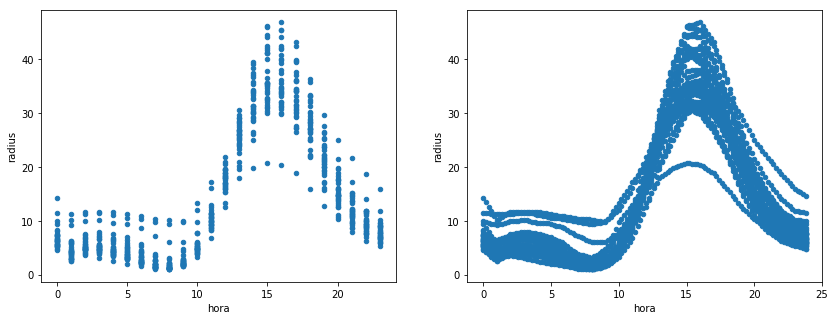

In [116]:
# Sanity Check
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
aux_ax = ax.flatten()
sc_o3_hora.plot.scatter(x='hora', y='radius', ax=aux_ax[0])
o3_hora.plot.scatter(x='hora', y='radius', ax=aux_ax[1])

In [118]:
plot_map(o3_hora[o3_hora.hora==16], colored=True, zoom_start=10)

In [119]:
plot_map(o3_hora[o3_hora.hora==3], colored=True, zoom_start=10)

In [120]:
# Poner las rutas correspondientes y cambiar el zoom.
route = '../map_frames_cdmx/'
title = '24 horas de Ozono en CDMX'
zoom = 10

Parallel(n_jobs=3, verbose=10)(delayed (go_ozone_frame) 
                                (count, hour, o3_hora, route, title, zoom) 
                                for count, hour in enumerate(o3_hora.hora.unique().tolist()))

[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed:   17.9s
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed:   23.9s
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed:   41.7s
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:   53.7s
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.5min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed:  1.9min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed:  2.7min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 120 out of 120 | elapsed:  4.0min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [124]:
# estas habían salido mal
for c in [67]:
    go_ozone_frame(c, o3_hora.hora.unique().tolist()[c],  o3_hora, route, title, zoom)

In [125]:
# Crear el GIF
gifname = route+'O3_'+title.lower().split()[-1]+'.gif'
os.system('convert -delay 5 -loop 0 %s*.png %s'%(route, gifname))

0